In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
file_path = '/content/AI Project Dataset - Final.csv'
data = pd.read_csv(file_path)

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 41']
data_cleaned = data.drop(columns=columns_to_drop)

encoder = LabelEncoder()
encoded_data = data_cleaned.apply(
    lambda col: encoder.fit_transform(col.astype(str)) if col.dtypes == 'object' else col
)

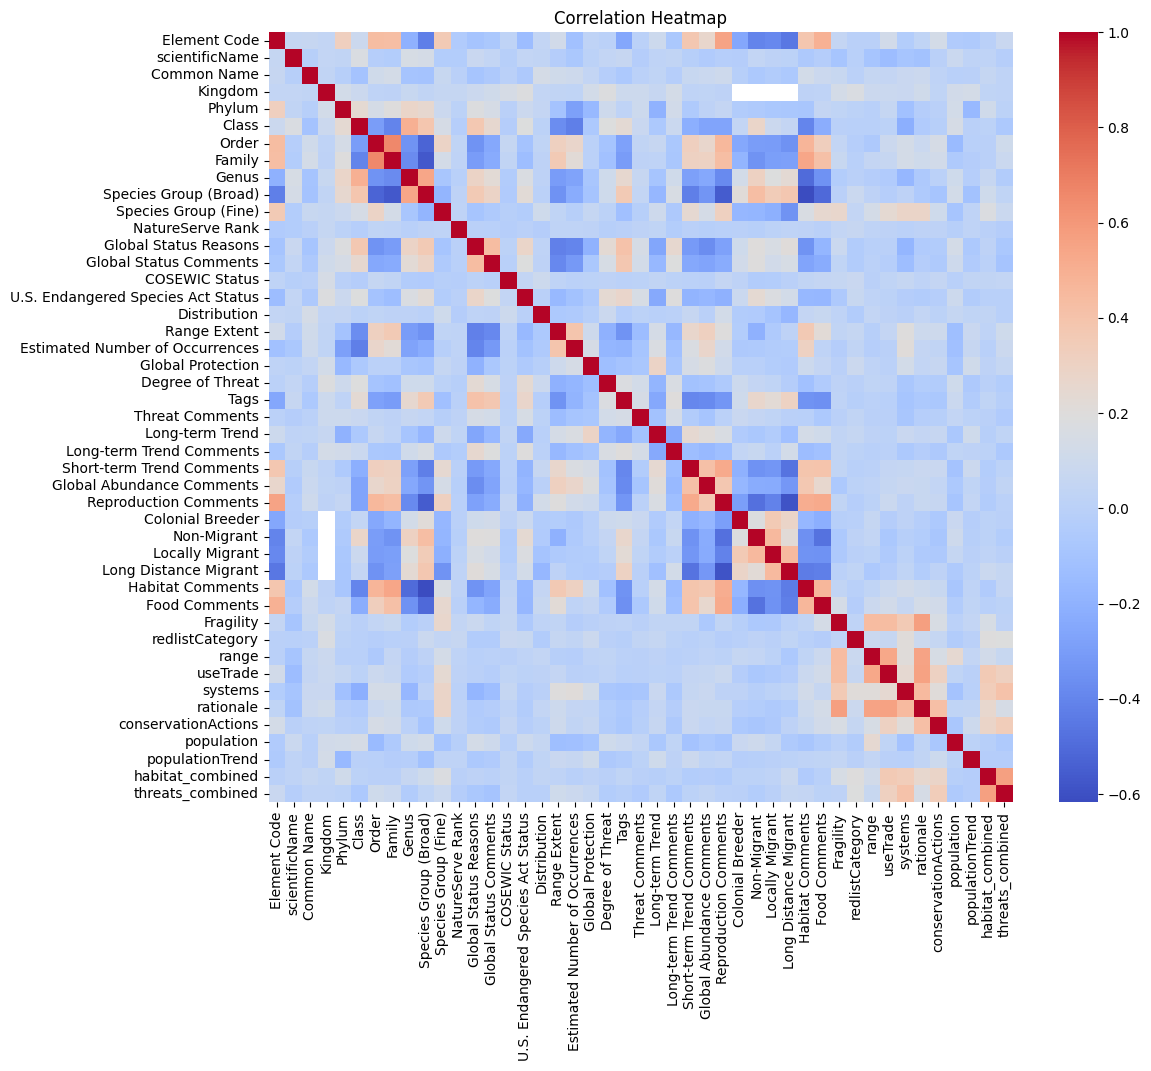

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Identify Status Columns
status_columns = [
    'NatureServe Rank', 'Global Status Reasons', 'Global Status Comments',
    'COSEWIC Status', 'U.S. Endangered Species Act Status', 'redlistCategory'
]
status_data = data_cleaned[status_columns]

# **Convert NaN values to strings in status_data:**
status_data = status_data.fillna('').astype(str)  # Replace NaN with empty string and convert to string

# Binarize the status columns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_multilabel = mlb.fit_transform(status_data.values)

# Use remaining features for prediction
X_multilabel = encoded_data.drop(columns=status_columns)

# Train-Test Split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_multilabel, y_multilabel, test_size=0.3, random_state=42
)

# Train MultiOutputClassifier
multi_rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
multi_rf_model.fit(X_train_ml, y_train_ml)

# Evaluate Multi-Label Model
y_pred_ml = multi_rf_model.predict(X_test_ml)
multi_label_accuracy = np.mean(y_pred_ml == y_test_ml)

print(f"Overall Multi-Label Accuracy: {multi_label_accuracy * 100:.2f}%")

Overall Multi-Label Accuracy: 99.89%


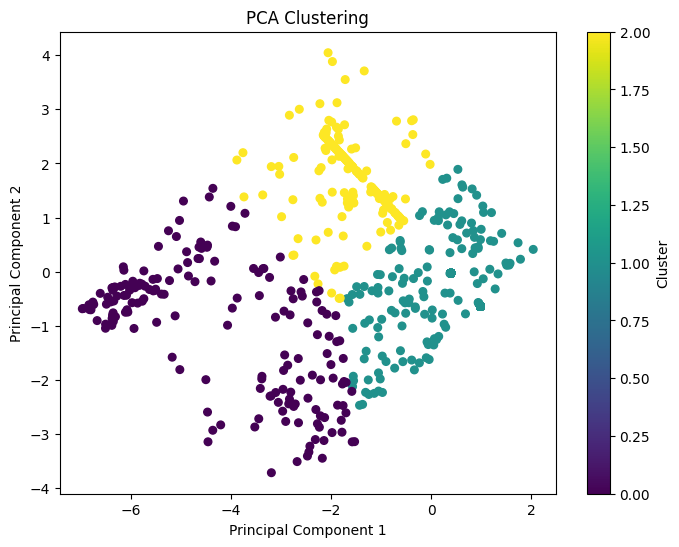

In [ ]:
# Clustering using Threats and Habitat
clustering_features = encoded_data[['threats_combined', 'habitat_combined']]
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_features)

# PCA for Clustering
pca_clustering = PCA(n_components=2)
clustering_pca_scaled = pca_clustering.fit_transform(clustering_scaled)

# KMeans with PCA-reduced data
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(clustering_pca_scaled)

# Visualize Clusters
plt.figure(figsize=(8, 6))
plt.scatter(
    clustering_pca_scaled[:, 0], clustering_pca_scaled[:, 1], c=clusters_pca, cmap='viridis', s=30
)
plt.title("PCA Clustering Threats and Habitat")
plt.xlabel("Threat Comments")
plt.ylabel("Habitat Comments")
plt.colorbar(label="Cluster")
plt.show()

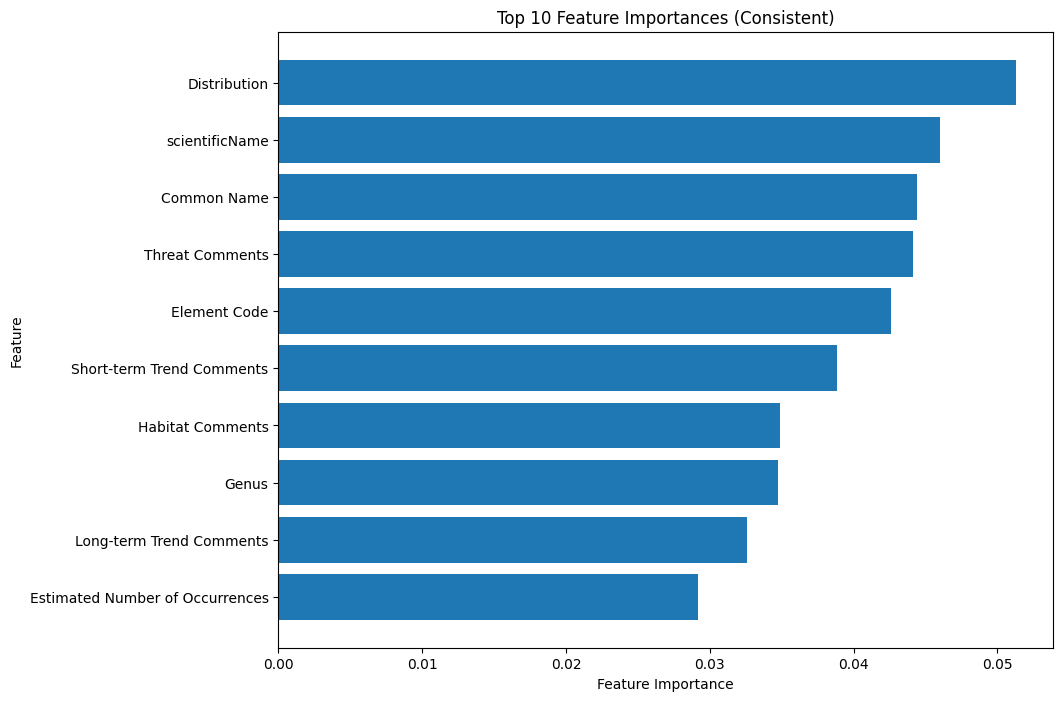

In [ ]:
# Ensure random states are fixed
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Train-Test Split with fixed random state
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_multilabel, y_multilabel, test_size=0.3, random_state=42
)

# Train MultiOutputClassifier with fixed random state
multi_rf_model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
multi_rf_model.fit(X_train_ml, y_train_ml)

# Extract consistent feature importance
feature_importances = np.mean(
    [est.feature_importances_ for est in multi_rf_model.estimators_], axis=0
)

# Visualize Consistent Feature Importance
important_features = pd.DataFrame({
    'Feature': X_multilabel.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(important_features['Feature'].head(10), important_features['Importance'].head(10))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Consistent)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

def prepare_data(data_path, target_column, key_features, min_samples_per_class=5):
    """
    Prepare data with proper handling of class imbalance and rare classes.
    """
    # Load data
    df_cleaned = pd.read_csv(data_path)

    # Select features and target
    X = df_cleaned[key_features]
    y = df_cleaned[target_column]

    # Check class distribution
    class_counts = y.value_counts()
    print("\nOriginal class distribution:")
    print(class_counts)

    # Filter classes with sufficient samples
    valid_classes = class_counts[class_counts >= min_samples_per_class].index
    filtered_indices = y.isin(valid_classes)

    X = X[filtered_indices]
    y = y[filtered_indices]

    print(f"\nClass distribution after filtering (minimum {min_samples_per_class} samples):")
    print(y.value_counts())

    return X, y

def preprocess_data(X, y):
    """
    Preprocess features with imputation and encoding.
    """
    # Impute missing values
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X = pd.DataFrame(cat_imputer.fit_transform(X), columns=X.columns)

    # One-hot encoding
    X = pd.get_dummies(X)

    return X, y

def apply_smote(X_train, y_train):
    """
    Apply SMOTE with proper error handling.
    """
    # Get the number of samples in minority class
    class_counts = Counter(y_train)
    min_samples = min(class_counts.values())

    # Calculate safe k_neighbors value
    k_neighbors = min(min_samples - 1, 5)  # Default is 5, but we'll use less if needed

    if k_neighbors < 1:
        print("Warning: Not enough samples for SMOTE. Using original data.")
        return X_train, y_train

    try:
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        print(f"\nClass distribution after SMOTE:")
        print(pd.Series(y_resampled).value_counts())
        return X_resampled, y_resampled
    except ValueError as e:
        print(f"Warning: SMOTE failed with error: {e}")
        print("Using original data instead.")
        return X_train, y_train

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple models.
    """
    models = {
        "Random Forest (Weighted)": RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_estimators=100
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            random_state=42,
            n_estimators=100
        ),
        "Logistic Regression (Weighted)": LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42
        ),
        "SVM (Weighted)": SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True,
            random_state=42
        )
    }

    results = []

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Get probabilities for ROC AUC
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        else:
            y_prob = model.decision_function(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        f1_weighted = report['weighted avg']['f1-score']

        # Calculate ROC AUC for multi-class
        try:
            roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
        except (ValueError, TypeError):
            roc_auc = "N/A"

        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Balanced Accuracy": balanced_acc,
            "F1 Weighted": f1_weighted,
            "ROC AUC": roc_auc
        })

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    return pd.DataFrame(results)

# Main execution
if __name__ == "__main__":
    # Configuration
    data_path = 'AI-Dataset-Cleaned.csv'
    target_column = 'NatureServe Rank'
    key_features = [
        'populationTrend', 'Tags', 'Degree of Threat',
        'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus'
    ]

    # Prepare and preprocess data
    X, y = prepare_data(data_path, target_column, key_features, min_samples_per_class=3)
    X, y = preprocess_data(X, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Apply SMOTE
    X_train, y_train = apply_smote(X_train.astype(float), y_train)

    # Train and evaluate models
    results_df = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Display final results
    print("\nFinal Model Comparison:")
    print(results_df)


Original class distribution:
NatureServe Rank
Secure                  405
Apparently Secure        58
Vulnerable               33
Imperiled                20
Unknown                  16
Critically Imperiled     12
Presumed Extinct          4
Unrankable                1
Unranked                  1
Name: count, dtype: int64

Class distribution after filtering (minimum 3 samples):
NatureServe Rank
Secure                  405
Apparently Secure        58
Vulnerable               33
Imperiled                20
Unknown                  16
Critically Imperiled     12
Presumed Extinct          4
Name: count, dtype: int64

Class distribution after SMOTE:
NatureServe Rank
Critically Imperiled    328
Secure                  328
Apparently Secure       328
Imperiled               328
Presumed Extinct        328
Vulnerable              328
Unknown                 328
Name: count, dtype: int64

Training Random Forest (Weighted)...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Classification Report:
                      precision    recall  f1-score   support

   Apparently Secure       0.20      0.09      0.12        11
Critically Imperiled       0.00      0.00      0.00         2
           Imperiled       0.33      0.33      0.33         3
    Presumed Extinct       0.00      0.00      0.00         1
              Secure       0.78      0.77      0.77        77
             Unknown       0.00      0.00      0.00         5
          Vulnerable       0.00      0.00      0.00        11

            accuracy                           0.55       110
           macro avg       0.19      0.17      0.18       110
        weighted avg       0.57      0.55      0.56       110


Training Gradient Boosting...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Classification Report:
                      precision    recall  f1-score   support

   Apparently Secure       0.25      0.09      0.13        11
Critically Imperiled       0.00      0.00      0.00         2
           Imperiled       0.20      0.33      0.25         3
    Presumed Extinct       0.00      0.00      0.00         1
              Secure       0.80      0.78      0.79        77
             Unknown       0.00      0.00      0.00         5
          Vulnerable       0.20      0.09      0.12        11

            accuracy                           0.57       110
           macro avg       0.21      0.18      0.19       110
        weighted avg       0.61      0.57      0.59       110


Training Logistic Regression (Weighted)...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


Classification Report:
                      precision    recall  f1-score   support

   Apparently Secure       0.07      0.09      0.08        11
Critically Imperiled       0.00      0.00      0.00         2
           Imperiled       0.11      0.33      0.17         3
    Presumed Extinct       0.00      0.00      0.00         1
              Secure       0.78      0.56      0.65        77
             Unknown       0.00      0.00      0.00         5
          Vulnerable       0.10      0.09      0.10        11

            accuracy                           0.42       110
           macro avg       0.15      0.15      0.14       110
        weighted avg       0.57      0.42      0.48       110


Training SVM (Weighted)...

Classification Report:
                      precision    recall  f1-score   support

   Apparently Secure       0.20      0.09      0.12        11
Critically Imperiled       0.00      0.00      0.00         2
           Imperiled       0.25      0.33      0.29 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(grid_search.best_estimator_, X_train_ml, y_train_ml, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", np.mean(scores))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Scores: [0.75       0.75       0.75       0.73563218 0.72413793]
Mean Accuracy: 0.7419540229885058
